# Caricamento delle collezioni e collegamento al database
Il Database è composto da 4 collezioni: food, global_dataset, global_inflation, consumer_price_index.
- food: contiene i dati relativi all'inflazione del cibo per i paesi dell'est europa
- global_dataset: contiene i dati relativi all'inflazione per i paesi del mondo divisi per 5 categorie
- global_inflation: contiene i dati relativi all'inflazione per i paesi del mondo divisi per anno
- consumer_price_index: contiene i dati relativi all'indice di prezzo al consumo per i paesi degli Stati Uniti

In [ ]:
import pymongo
import utils 
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["ProgettoBD2"]
food = db["food"]
global_dataset = db["global_dataset"]
global_inflation = db["global_inflation"]
us_cpi = db["consumer_price_index"]

## Collection: Food
- Query per estrarre i paesi presenti nella collezione \
I paesi presenti nella collezione sono principalmente paesi dell'est Europa

In [74]:
countries = food.distinct("country")
countries

['Afghanistan',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Gambia, The',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Lao PDR',
 'Lebanon',
 'Liberia',
 'Mali',
 'Mozambique',
 'Myanmar',
 'Niger',
 'Nigeria',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Syrian Arab Republic',
 'Yemen, Rep.']

## Collection: Global Dataset
Lista dei paesi presenti nella collezione

In [75]:
countries = global_dataset.distinct("Country")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 'Croatia',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Gui

L'inflazione è suddivisa in categorie.
- Query per la stampa delle categorie presenti nella collezione

In [76]:
global_dataset.distinct("Series Name")

['Energy Consumer Price Inflation',
 'Food Consumer Price Inflation',
 'Headline Consumer Price Inflation',
 'Official Core Consumer Price Inflation',
 'Producer Price Inflation']

# Unione Europea 
Si è deciso di analizzare i paesi dell'Unione Europea presenti nella collezione global_dataset

- Estrazione dei paesi dell'Unione Europea presenti nella collezione

In [77]:
query = {"Country Code": {"$in": ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]}}

europeanCountries = global_dataset.find(query)

europeanCountriesList = global_dataset.distinct("Country", query)
for country in europeanCountriesList:
    print(country)

Austria
Belgium
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovak Republic
Slovakia
Slovenia
Spain
Sweden


Query che fa la media anno per anno del tasso di inflazione nei paesi dell'unione europea di tutte le categorie.
In sostanza vengono eliminate le categorie aggregando i 5 valori per ogni anno in una media. 

In [78]:
# Esecuzione dell'aggregazione
result = utils.get_avg_infl_eur(global_dataset, europeanCountriesList)
# Stampa dei risultati
for doc in result:
    print(doc)

{'_id': 'Germany', '1970': 3.7363922, '1971': 4.886, '1972': 4.746, '1973': 8.797999999999998, '1974': 9.752, '1975': 6.386, '1976': 4.682, '1977': 3.186, '1978': 2.158, '1979': 6.95, '1980': 6.581999999999999, '1981': 8.19, '1982': 6.016, '1983': 2.072, '1984': 2.528, '1985': 2.242, '1986': -2.538, '1987': -2.172, '1988': 0.356, '1989': 3.184, '1990': 2.85, '1991': 3.524, '1992': 4.593999999999999, '1993': 3.7479999999999998, '1994': 2.352, '1995': 1.886, '1996': 0.9800000000000001, '1997': 1.8059999999999998, '1998': 0.748, '1999': 0.041999999999999996, '2000': 1.734, '2001': 3.08, '2002': 0.578, '2003': 1.266, '2004': 1.1640000000000001, '2005': 1.738, '2006': 2.338, '2007': 2.238, '2008': 3.54, '2009': -0.5199999999999999, '2010': 1.1800000000000002, '2011': 2.6, '2012': 2.1239999999999997, '2013': 1.686, '2014': 0.72, '2015': 0.366, '2016': 0.254, '2017': 1.7759999999999998, '2018': 1.786, '2019': 1.26, '2020': 0.734, '2021': 5.324, '2022': 16.68, '2023': None, '2024': None}
{'_id

Analizzata l'inflazione nell'Unione Europea come un unicum negli anni
 

In [79]:
europeanCountriesList = global_dataset.distinct("Country", query)
result = utils.get_food_inflation_eur_per_year(global_dataset, europeanCountriesList)
output = {}

  # Riempimento del dizionario con i risultati
for doc in result: 
    doc.pop('_id')  # Rimuove la chiave '_id' non necessaria
    output.update(doc)

print(output)

{'1970': 6.397862595419848, '1971': 7.006590909090909, '1972': 9.335338345864661, '1973': 18.446666666666665, '1974': 26.777910447761197, '1975': 18.41206106870229, '1976': 14.271297709923664, '1977': 19.17953488372093, '1978': 12.90453125, '1979': 15.521349206349207, '1980': 20.60152, '1981': 17.201603053435115, '1982': 16.643283582089552, '1983': 20.067697841726616, '1984': 28.46785714285714, '1985': 106.12627737226278, '1986': 26.15737588652482, '1987': 28.48169014084507, '1988': 27.79986013986014, '1989': 100.51146853146854, '1990': 168.51965277777776, '1991': 66.58344594594595, '1992': 105.64786666666667, '1993': 121.2273509933775, '1994': 114.18649350649352, '1995': 31.614777070063692, '1996': 12.14, '1997': 16.17576923076923, '1998': 9.383860759493672, '1999': 8.56515923566879, '2000': 6.281528662420382, '2001': 6.6874213836477985, '2002': 6.466419753086419, '2003': 8.08425, '2004': 7.956625, '2005': 7.4868292682926825, '2006': 12.646287425149703, '2007': 52.17844311377245, '200

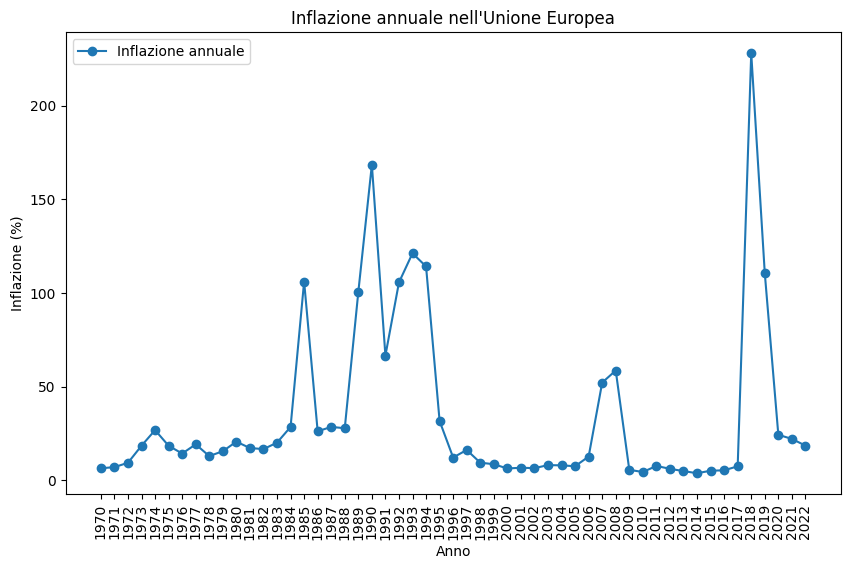

In [80]:
import matplotlib.pyplot as plt

# Estrazione degli anni e dei valori di inflazione dal dizionario
anni = list(output.keys())
inflazione = list(output.values())

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(anni, inflazione, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title('Inflazione annuale nell\'Unione Europea')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Integrazione con food
\
Query per estrarre i dati dell'inflazione dei paesi europei sul cibo. \
 Modo per integrare la collezione "food" dove mancano i dati sull'inflazione dei paesi Europei


In [81]:
europeanCountriesList = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]

result = utils.get_eu_food_infl_countries(global_dataset, europeanCountriesList)

for doc in result:
    print(doc)


{'_id': ObjectId('6655ab774d00c539704c41d1'), '1970': 4.42, '1971': 3.21, '1972': 5.32, '1973': 7.19, '1974': 8.14, '1975': 6.05, '1976': 5.31, '1977': 5.59, '1978': 2.93, '1979': 2.48, '1980': 4.5, '1981': 5.89, '1982': 4.23, '1983': 2.13, '1984': 5.44, '1985': 2.0, '1986': 1.99, '1987': 0.24, '1988': 0.12, '1989': 0.78, '1990': 2.82, '1991': 4.08, '1992': 3.71, '1993': 2.27, '1994': 1.38, '1995': -1.72, '1996': 0.13, '1997': 1.53, '1998': 1.93, '1999': -0.63, '2000': 0.65, '2001': 3.64, '2002': 1.34, '2003': 1.79, '2004': 1.92, '2005': 1.24, '2006': 1.88, '2007': 4.21, '2008': 6.29, '2009': 0.2, '2010': 0.48, '2011': 4.24, '2012': 3.19, '2013': 3.47, '2014': 1.94, '2015': 0.83, '2016': 0.73, '2017': 2.37, '2018': 1.52, '2019': 1.02, '2020': 2.33, '2021': 0.78, '2022': 10.23, 'Country Code': 'AUT', 'IMF Country Code': 122, 'Country': 'Austria', 'Indicator Type': 'Inflation', 'Series Name': 'Food Consumer Price Inflation', 'Note': 'Food and non-acoholic beverage'}
{'_id': ObjectId('665

## Collection: Global Inflation
Lista dei paesi presenti nella collezione

In [82]:
countries = global_inflation.distinct("country_name")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 "China, People's Republic of",
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep. of the',
 'Congo, Republic of ',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 

Estrazione Paese con maggiore inflazione in base all'anno

In [83]:
# Query per trovare il paese con la massima inflazione in un anno specifico
anno = 2024
max_inflation = utils.get_max_infl_year(global_inflation, anno)

country_max_infl = global_inflation.find_one({"_id": max_inflation.next()['_id']})
country_name = country_max_infl['country_name']

print(f"Il paese con la maggiore inflazione nel {anno} è: {country_name} con un valore di {country_max_infl[str(anno)]}%")

Il paese con la maggiore inflazione nel 2024 è: Zimbabwe con un valore di 222.4%


In [84]:
del country_max_infl['_id']
del country_max_infl['country_name']
del country_max_infl['indicator_name']

Plot dell'inflazione annuale per il paese con la maggiore inflazione precedentemente calcolata

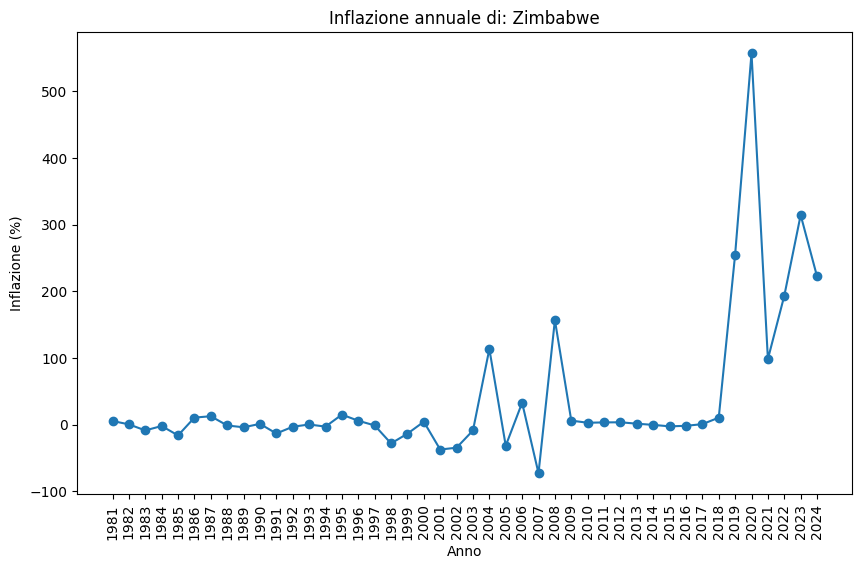

In [85]:
import matplotlib.pyplot as plt

anni = list(country_max_infl.keys())
inflazione = list(country_max_infl.values())
plt.figure(figsize=(10, 6))
plt.plot(anni, inflazione, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title(f'Inflazione annuale di: {country_name}')
plt.xticks(rotation=90)
plt.show()

Inflazione media per paese

In [86]:
country_name = "Italy"
avg_ita_infl = utils.get_avg_infl_years(global_inflation, country_name)
print(f"L'inflazione media in {country_name} dal 1980 al 2024 è {avg_ita_infl.next()['avgInflation']:.2f}%")

L'inflazione media in Italy dal 1980 al 2024 è 4.66%


In [87]:
# Codice USA | Map e reduce?

## Collection: Consumer Price Index